[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/descriptor_matching.ipynb)

# Image matching example with kornia local features: TFeat, MKD, OriNet, HyNet and OpenCV detector

It is possible to use OpenCV local features, such as SIFT with kornia via [kornia_moons](https://ducha-aiki.github.io/kornia_moons) library.


First, we will install everything needed:

Installing the and pydegensac for good RANSAC

*  fresh version of [kornia](https://github.com/kornia/kornia) for [MKD](https://arxiv.org/pdf/1707.07825.pdf) and [TFeat](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf) descriptors
*  fresh version of OpenCV for SIFT features and MAGSAC++
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions between OpenCV and kornia formats


In [ ]:
%%capture
!pip install kornia
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [1]:
%%capture
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
!wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg

First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and Pydegensac as RANSAC.


### Imports

In [6]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
import pydegensac
from kornia_moons.feature import *

def load_timg(fname, device=torch.device('cpu')):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    timg = K.image_to_tensor(img, False).float().to(device)/255.
    return timg

##  Using OpenCV SIFT as is and converting it manually

In [2]:


def sift_matching(fname1, fname2):
    img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)

    # OpenCV SIFT
    sift = cv2.SIFT_create(8000)
    kps1, descs1 = sift.detectAndCompute(img1, None)
    kps2, descs2 = sift.detectAndCompute(img2, None)
    
    # Converting to kornia for matching via AdaLAM
    lafs1 = laf_from_opencv_SIFT_kpts(kps1)
    lafs2 = laf_from_opencv_SIFT_kpts(kps2) 
    dists, idxs = KF.match_adalam(torch.from_numpy(descs1), torch.from_numpy(descs2),
                                  lafs1, lafs2,
                                  hw1=img1.shape[:2],
                                  hw2=img2.shape[:2])
    
    # Converting back to kornia via to use OpenCV MAGSAC++
    tentatives = cv2_matches_from_kornia(dists, idxs)
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    F, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 100000)
    
    # Drawing matches using kornia_moons
    draw_LAF_matches(
        lafs1,
        lafs2,
        idxs,
        img1,
            img2,
            inliers_mask,
            draw_dict={'inlier_color': (0.2, 1, 0.2),
                       'tentative_color': None, 
                       'feature_color': None, 'vertical': False})
    print (f'{inliers_mask.sum()} inliers found')
    return   



12 inliers found


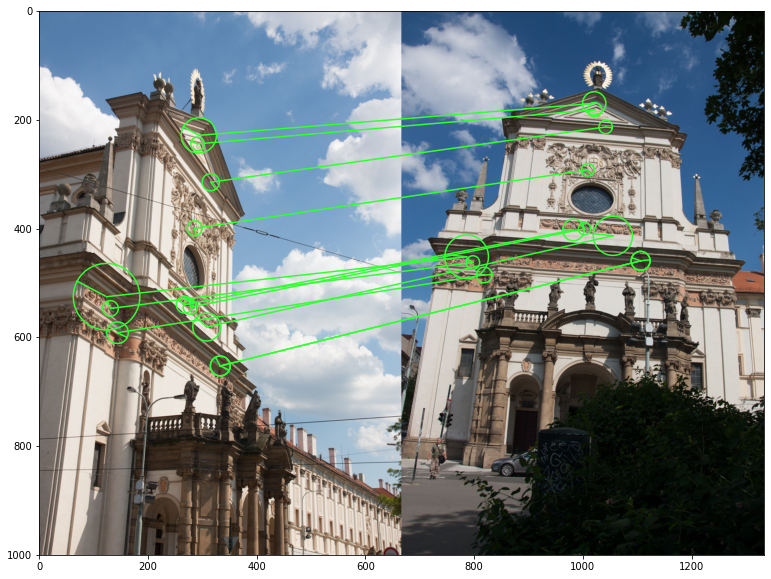

In [5]:
fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'
sift_matching(fname1, fname2)

##  Using OpenCV SIFT with kornia matcher

Now we need to define a function to feed the OpenCV keypoints into local descriptors from kornia. Luckily, that is easy with the help of kornia_moons.

In [7]:
def get_matching_kpts(lafs1, lafs2, idxs):
    src_pts = KF.get_laf_center(lafs1).view(-1, 2)[idxs[:, 0]].detach().cpu().numpy()
    dst_pts = KF.get_laf_center(lafs2).view(-1, 2)[idxs[:, 1]].detach().cpu().numpy()
    return src_pts, dst_pts

def sift_korniadesc_matching(fname1, fname2, descriptor):
    timg1 = load_timg(fname1)
    timg2 = load_timg(fname2)
    
    sift = OpenCVDetectorKornia(cv2.SIFT_create(8000))
    local_feature = KF.LocalFeature(sift, KF.LAFDescriptor(descriptor))
    
    lafs1, resps1, descs1 = local_feature(K.color.rgb_to_grayscale(timg1))
    lafs2, resps2, descs2 = local_feature(K.color.rgb_to_grayscale(timg2))
    
    dists, idxs = KF.match_adalam(descs1[0], descs2[0], lafs1, lafs2, 
                                  hw1=timg1.shape[2:],
                                  hw2=timg2.shape[2:])

    src_pts, dst_pts = get_matching_kpts(lafs1, lafs2, idxs)
    F, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 100000)
    draw_LAF_matches(lafs1,
                     lafs2,
                     idxs,
                     K.tensor_to_image(timg1),
                     K.tensor_to_image(timg2),
                     inliers_mask,
                     draw_dict={'inlier_color': (0.2, 1, 0.2),
                               'tentative_color': None, 
                               'feature_color': None, 'vertical': False})
    print (f'{inliers_mask.sum()} inliers found')

Now let's try kornia new descriptors -- MKD and TFeat. 
MKD is one of the best handcrafted local feature descriptors, presented in IJCV 2018 paper "[Understanding and Improving Kernel Local Descriptors](https://arxiv.org/abs/1811.11147)".


14 inliers found


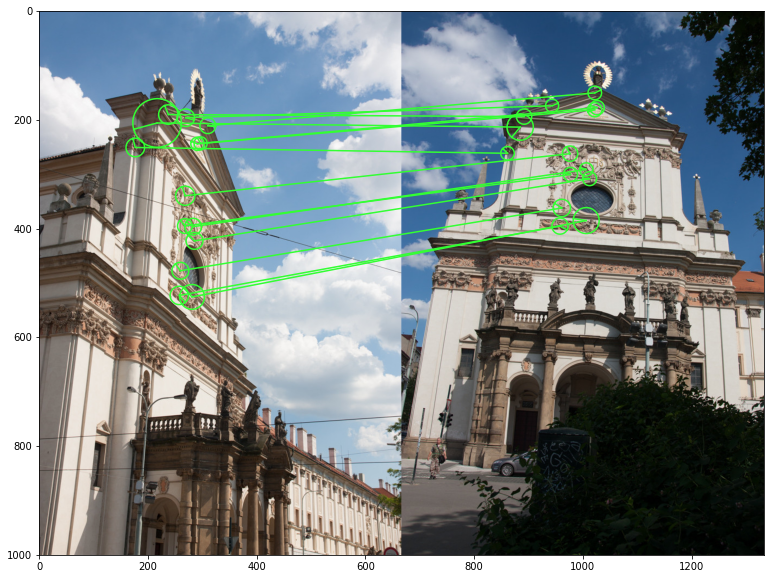

In [8]:
mkd = KF.MKDDescriptor(32)
with torch.inference_mode():
    sift_korniadesc_matching(fname1, fname2, mkd)

Result seems 2 inliers better than with SIFTs. Let's try TFeat - lightweight deep learning-based descriptor from BMVC 2016 paper "[Learning local feature descriptors with triplets and shallow convolutional neural networks](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf)"

16 inliers found


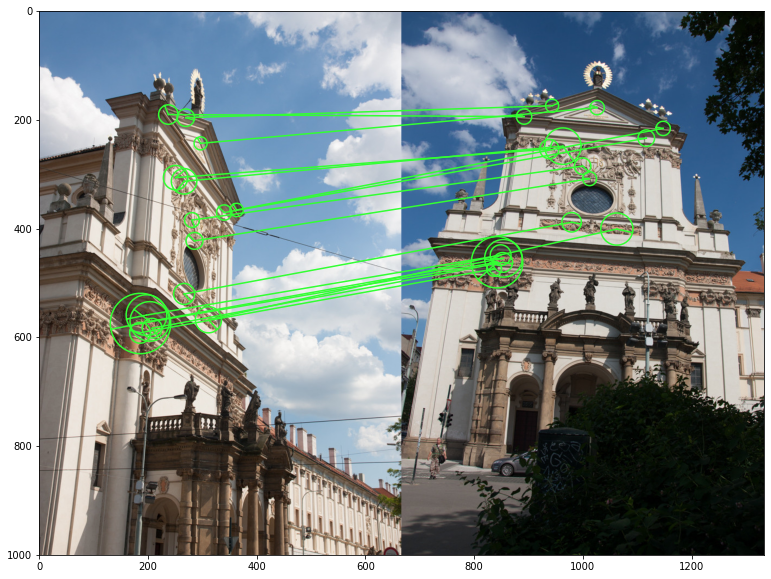

In [9]:
tfeat = KF.TFeat(True)
with torch.inference_mode():
    sift_korniadesc_matching(fname1, fname2, tfeat)

## Good old HardNet
In the worst-case we can always fall back to the HardNet -- more robust, but also slower than TFeat and MKD, descriptor

36 inliers found


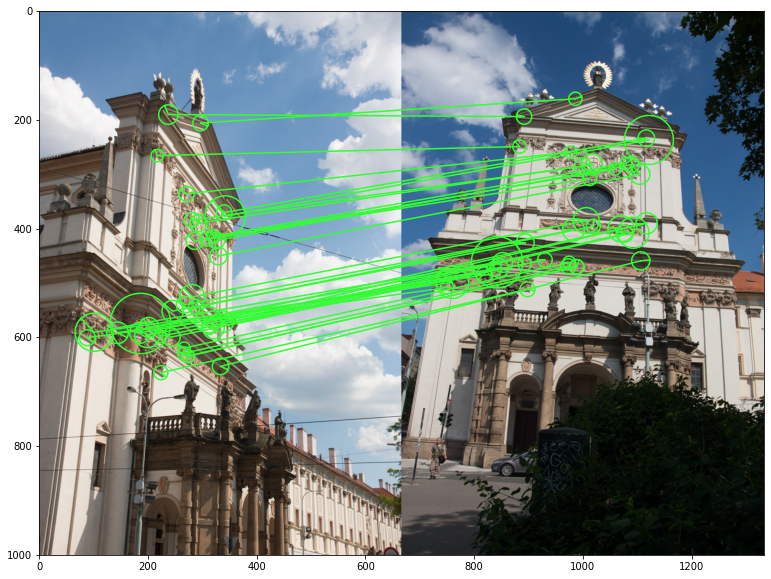

In [10]:
device=torch.device('cpu')
hardnet = KF.HardNet(True).eval()
with torch.inference_mode():
    sift_korniadesc_matching(fname1, fname2, hardnet)

## AffNet

We haven't done yet! SIFT detector is a great tool, but we can improve it by using deep learned affine shape estimation -- [AffNet](https://arxiv.org/abs/1711.06704).
You can do it, using a single function wrapper - `OpenCVDetectorWithAffNetKornia`.

In [11]:
def siftaffnet_korniadesc_matching(fname1, fname2, descriptor):
    timg1 = load_timg(fname1)
    timg2 = load_timg(fname2)
    
    # Magic is here
    sift = OpenCVDetectorWithAffNetKornia(cv2.SIFT_create(8000))
    
    local_feature = KF.LocalFeature(sift, KF.LAFDescriptor(descriptor))
    with torch.inference_mode():
        lafs1, resps1, descs1 = local_feature(K.color.rgb_to_grayscale(timg1))
        lafs2, resps2, descs2 = local_feature(K.color.rgb_to_grayscale(timg2))
        dists, idxs = KF.match_adalam(descs1[0], descs2[0], lafs1, lafs2, 
                                      hw1=timg1.shape[2:],
                                      hw2=timg2.shape[2:])
    
    src_pts, dst_pts = get_matching_kpts(lafs1, lafs2, idxs)
    
    F, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 100000)
    draw_LAF_matches(lafs1,
                     lafs2,
                     idxs,
                     K.tensor_to_image(timg1),
                     K.tensor_to_image(timg2),
                     inliers_mask,
                     draw_dict={'inlier_color': (0.2, 1, 0.2),
                               'tentative_color': None, 
                               'feature_color': None, 'vertical': False})
    print (f'{inliers_mask.sum()} inliers found')

51 inliers found


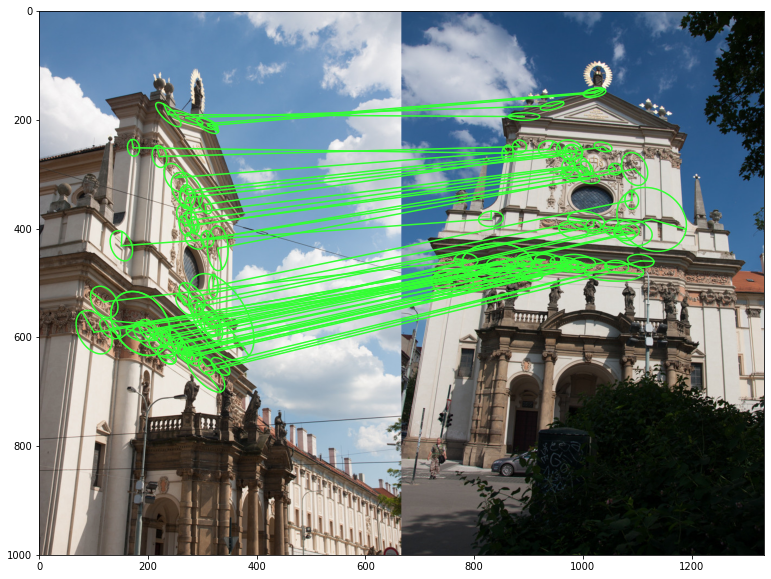

In [12]:
siftaffnet_korniadesc_matching(fname1, fname2, hardnet)

## [HyNet](https://kornia.readthedocs.io/en/latest/_modules/kornia/feature/hynet.html)



50 inliers found


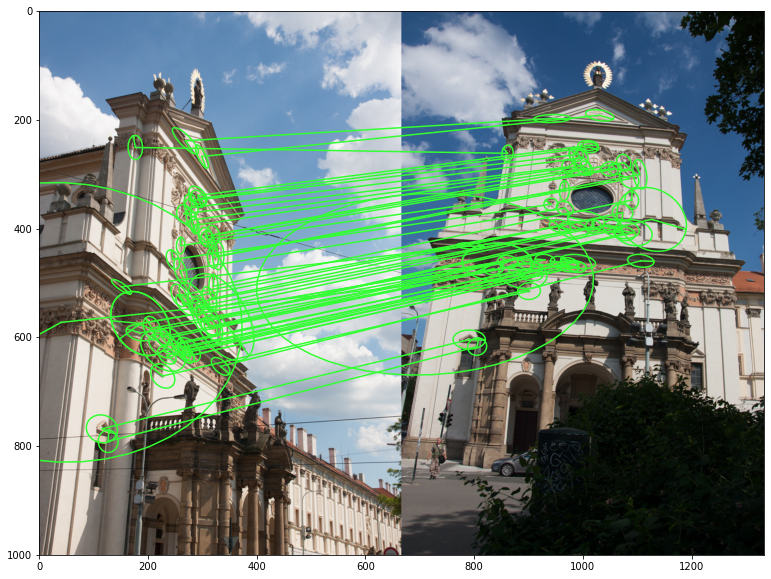

In [13]:
siftaffnet_korniadesc_matching(fname1, fname2, KF.HyNet(True).eval())

## SOSNet

53 inliers found


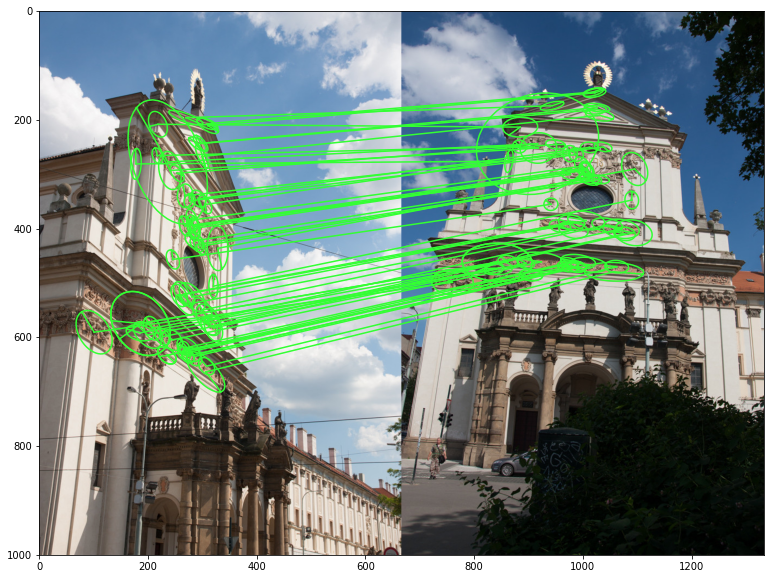

In [14]:
siftaffnet_korniadesc_matching(fname1, fname2, KF.SOSNet(True).eval())

## HardNet8

44 inliers found


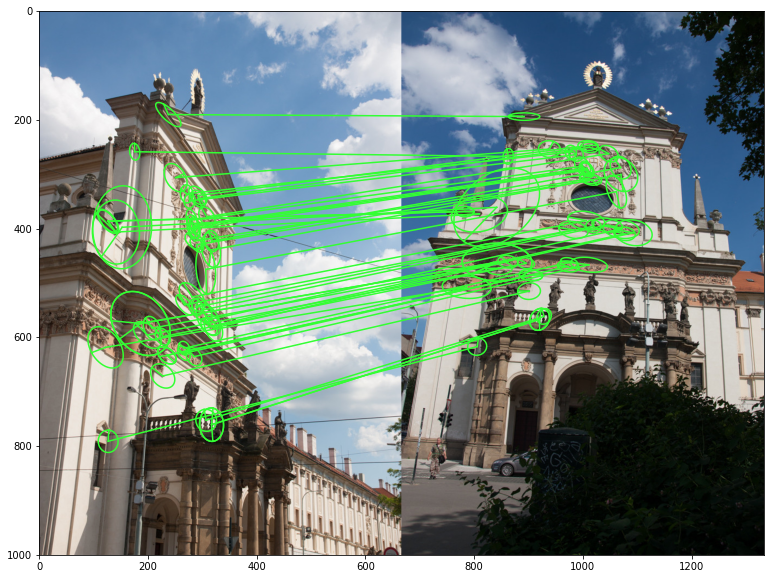

In [11]:
siftaffnet_korniadesc_matching(fname1, fname2, KF.HardNet8(True).eval())